In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
os.listdir('data')

['Env_QH.csv',
 'micro_sud3.pkl',
 'AllPM_QH.csv',
 'micro_sud3_normalized.pkl',
 'AllNO2_QH.csv']

In [3]:
df = pd.read_pickle('data/micro_sud3_normalized.pkl')
df = df.reset_index()

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df, look_back):
    i = look_back
    while True:
        sequence = df.iloc[i - look_back:i]
        yield np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8) , np.array(sequence['NO2_ref'])
        i += 1
        if i == len(df):
            i = look_back
            
def dataframe_to_xy_test(df, look_back):
    X_test, y_test = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X_test.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y_test.append(np.array(df.iloc[i]['NO2_ref']))
        i += 1
        if i == len(df):
            break
            
    return np.array(X_test), np.array(y_test)
            
        
df_test, df_train = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train = dataframe_to_xy(df_train, 10)
X_valid = dataframe_to_xy(df_valid, 10)
X_test, y_test = dataframe_to_xy_test(df_test, 10)

In [4]:
def dataframe_to_xy_no_generator(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y.append(np.array(df.iloc[i]['NO2_ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

In [5]:
X_train, y_train = dataframe_to_xy_no_generator(df_train, 24)
X_valid, y_valid = dataframe_to_xy_no_generator(df_valid, 24)
X_test, y_test = dataframe_to_xy_no_generator(df_test, 24)

In [6]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim, activation='relu'))
    #model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim, activation='relu'))
    #model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_dim, activation='relu'))
    #model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

In [7]:
model = simple_rnn_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1 ,shuffle=False)

Train on 1103 samples, validate on 539 samples
Epoch 1/5000
1103/1103 [==============================] - 1s - loss: 2108.7710 - val_loss: 2352.3162
Epoch 2/5000
1103/1103 [==============================] - 0s - loss: 1557.4117 - val_loss: 2468.2001
Epoch 3/5000
1103/1103 [==============================] - 0s - loss: 1770.6605 - val_loss: 2043.1367
Epoch 4/5000
1103/1103 [==============================] - 0s - loss: 1366.1160 - val_loss: 2381.8224
Epoch 5/5000
1103/1103 [==============================] - 0s - loss: 1737.4124 - val_loss: 2035.8233
Epoch 6/5000
1103/1103 [==============================] - 0s - loss: 1486.7342 - val_loss: 2336.1220
Epoch 7/5000
1103/1103 [==============================] - 0s - loss: 1784.3976 - val_loss: 2174.9146
Epoch 8/5000
1103/1103 [==============================] - 0s - loss: 1386.1317 - val_loss: 1395.4886
Epoch 9/5000
1103/1103 [==============================] - 0s - loss: 937.9678 - val_loss: 1175.1488
Epoch 10/5000
1103/1103 [====================

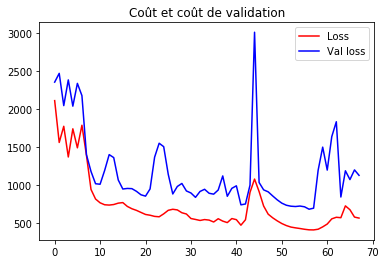

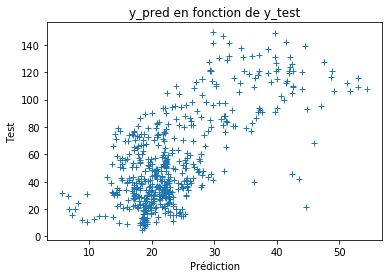

In [9]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [10]:
model = lstm_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1103 samples, validate on 539 samples
Epoch 1/5000
1103/1103 [==============================] - 4s - loss: 2155.3043 - val_loss: 2702.5635
Epoch 2/5000
1103/1103 [==============================] - 3s - loss: 1998.5100 - val_loss: 4650.9607
Epoch 3/5000
1103/1103 [==============================] - 3s - loss: 2553.0127 - val_loss: 2358.7088
Epoch 4/5000
1103/1103 [==============================] - 3s - loss: 1544.5757 - val_loss: 2677.7464
Epoch 5/5000
1103/1103 [==============================] - 3s - loss: 31977.3837 - val_loss: 2219.0619
Epoch 6/5000
1103/1103 [==============================] - 3s - loss: 1512.7841 - val_loss: 2164.4490
Epoch 7/5000
1103/1103 [==============================] - 3s - loss: 1341.7116 - val_loss: 2076.5876
Epoch 8/5000
1103/1103 [==============================] - 3s - loss: 1256.0104 - val_loss: 1972.2738
Epoch 9/5000
1103/1103 [==============================] - 3s - loss: 1201.7537 - val_loss: 1822.2874
Epoch 10/5000
1103/1103 [==================

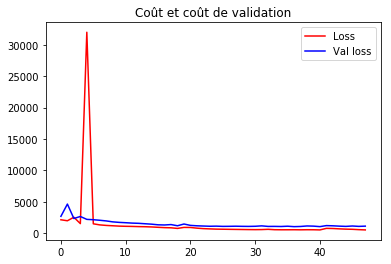

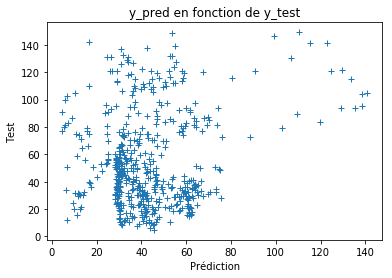

In [12]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [13]:
model = gru_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1103 samples, validate on 539 samples
Epoch 1/5000
1103/1103 [==============================] - 3s - loss: 2145.5479 - val_loss: 2755.4116
Epoch 2/5000
1103/1103 [==============================] - 2s - loss: 2122.6831 - val_loss: 2697.1933
Epoch 3/5000
1103/1103 [==============================] - 2s - loss: 1913.2269 - val_loss: 1470.5104
Epoch 4/5000
1103/1103 [==============================] - 2s - loss: 941.3937 - val_loss: 1175.4210
Epoch 5/5000
1103/1103 [==============================] - 2s - loss: 672.1265 - val_loss: 1179.1228
Epoch 6/5000
1103/1103 [==============================] - 2s - loss: 690.2375 - val_loss: 986.7637
Epoch 7/5000
1103/1103 [==============================] - 2s - loss: 641.6373 - val_loss: 977.1163
Epoch 8/5000
1103/1103 [==============================] - 2s - loss: 594.2535 - val_loss: 783.0976
Epoch 9/5000
1103/1103 [==============================] - 2s - loss: 581.6901 - val_loss: 720.8078
Epoch 10/5000
1103/1103 [=============================

1103/1103 [==============================] - 2s - loss: 224.6509 - val_loss: 474.7204
Epoch 83/5000
1103/1103 [==============================] - 2s - loss: 210.5067 - val_loss: 383.5480
Epoch 84/5000
1103/1103 [==============================] - 2s - loss: 205.1033 - val_loss: 414.5309
Epoch 85/5000
1103/1103 [==============================] - 2s - loss: 218.8389 - val_loss: 457.5388
Epoch 86/5000
1103/1103 [==============================] - 2s - loss: 196.1690 - val_loss: 376.7492
Epoch 87/5000
1103/1103 [==============================] - 2s - loss: 190.5981 - val_loss: 394.8716
Epoch 88/5000
1103/1103 [==============================] - 2s - loss: 184.4359 - val_loss: 417.8232
Epoch 89/5000
1103/1103 [==============================] - 2s - loss: 181.5565 - val_loss: 498.0445
Epoch 90/5000
1103/1103 [==============================] - 2s - loss: 193.5476 - val_loss: 427.2524
Epoch 91/5000
1103/1103 [==============================] - 2s - loss: 185.4567 - val_loss: 406.9913
Epoch 92/5000


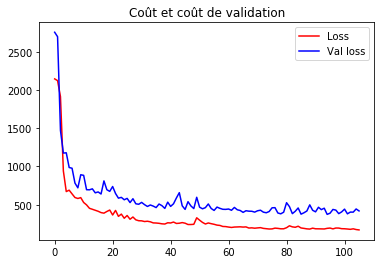

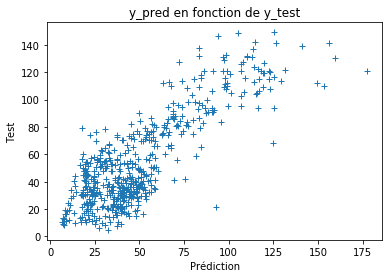

In [15]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()